## Executed the below cells on Colab Enterprise on GPU and saved the model weights

In [3]:
!unzip /Image_bwmask_dataset.zip -d /


Archive:  /Image_bwmask_dataset.zip
replace /Image_bwmask_dataset/ground_truth_mask/ground_truth_mask/0001.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  1


In [5]:
# Import Libraries
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import MeanIoU
from sklearn.model_selection import train_test_split
from tensorflow.keras import mixed_precision
# from tensorflow.keras.mixed_precision import experimental as mixed_precision
import numpy as np
import cv2
import os





In [6]:
# # Set the mixed precision policy
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_policy(policy)
tf.keras.mixed_precision.set_global_policy('mixed_float16')

In [7]:
# Function to load and preprocess data
def load_data(image_dir, mask_dir, input_size=(320, 320)):
    images = []
    masks = []

    assert os.path.exists(image_dir), f"Image directory {image_dir} does not exist"
    assert os.path.exists(mask_dir), f"Mask directory {mask_dir} does not exist"
    print(f"Loading data from {image_dir} and {mask_dir}")

    for img_name in sorted(os.listdir(image_dir)):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, img_name.replace('.jpg', '.png'))

        # Read and resize image and mask
        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        image = cv2.resize(image, input_size)
        mask = cv2.resize(mask, input_size)

        images.append(image)
        masks.append(mask)

    # Convert to numpy arrays and normalize
    images = np.array(images) / 255.0
    masks = np.expand_dims(np.array(masks) / 255.0, axis=-1)

    print(f"Loaded {len(images)} images with shape {images.shape} and {len(masks)} masks with shape {masks.shape}")
    return images, masks

In [5]:
# Function to build the U-2-Net model
def RSU_block(x, filters, pool=True):
    print(f"RSU Block: Input shape: {x.shape}, filters: {filters}, pool: {pool}")

    # Initial Convolution block
    h = Conv2D(filters, (3, 3), padding='same')(x)
    h = BatchNormalization()(h)
    h = Activation('relu')(h)

    # Downsampling and RSU block recursion
    if pool:
        p = MaxPooling2D((2, 2))(h)
        p = RSU_block(p, filters, pool=False)
        p = UpSampling2D((2, 2))(p)
    else:
        p = h

    # Upsampling and skip connections
    h = Conv2D(filters, (3, 3), padding='same')(p)
    h = BatchNormalization()(h)
    h = Activation('relu')(h)

    return Concatenate()([x, h])




In [4]:
# Function to define the U-2-Net architecture
def U2Net(input_size=(320, 320, 3)):
    print("Building U2Net model...")
    inputs = Input(input_size)

    # Stage 1 - 4 of downsampling and upsampling
    h1 = RSU_block(inputs, 64)
    p1 = MaxPooling2D((2, 2))(h1)
    h2 = RSU_block(p1, 128)
    p2 = MaxPooling2D((2, 2))(h2)
    h3 = RSU_block(p2, 256)
    p3 = MaxPooling2D((2, 2))(h3)
    h4 = RSU_block(p3, 512)

    # UpSampling and Concatenation stages
    u3 = UpSampling2D((2, 2))(h4)
    u3 = Concatenate()([u3, h3])
    u3 = RSU_block(u3, 256, pool=False)

    u2 = UpSampling2D((2, 2))(u3)
    u2 = Concatenate()([u2, h2])
    u2 = RSU_block(u2, 128, pool=False)

    u1 = UpSampling2D((2, 2))(u2)
    u1 = Concatenate()([u1, h1])
    u1 = RSU_block(u1, 64, pool=False)

    # Final output
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(u1)

    model = Model(inputs=[inputs], outputs=[outputs])
    print("U2Net model built successfully!")
    return model



In [10]:

# Dice score and loss functions with debugging
def dice_score(y_val, y_pred, smooth=1e-6):
    y_val_f = tf.keras.backend.flatten(tf.cast(y_val, tf.float64))
    y_pred_f = tf.keras.backend.flatten(tf.cast(y_pred, tf.float64))
    intersection = tf.keras.backend.sum(y_val_f * y_pred_f)

    # Debugging: Print intersection values
    print(f"Dice Score - Intersection: {intersection}")

    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_val_f) + tf.keras.backend.sum(y_pred_f) + smooth)


In [11]:


def dice_loss(y_val, y_pred, smooth=1e-6, gama=1):
    y_pred = tf.convert_to_tensor(y_pred)
    y_val = tf.cast(y_val, y_pred.dtype)
    smooth = tf.cast(smooth, y_pred.dtype)
    gama = tf.cast(gama, y_pred.dtype)

    nominator = 2 * tf.reduce_sum(tf.multiply(y_pred, y_val)) + smooth
    denominator = tf.reduce_sum(y_pred ** gama) + tf.reduce_sum(y_val ** gama) + smooth

    # Debugging: Print numerator and denominator
    print(f"Dice Loss - Nominator: {nominator}, Denominator: {denominator}")

    return 1 - tf.divide(nominator, denominator)



In [12]:
# Train the model on subsets of data
def train_on_subsets(model, train_data, val_data, batch_size, epochs, subset_size=500):
    total_data = len(train_data[0])
    for start in range(0, total_data, subset_size):
        end = min(start + subset_size, total_data)
        subset_train_data = (train_data[0][start:end], train_data[1][start:end])
        print(f"Training on subset: {start} to {end}")

        # Train the model on the subset of data
        model.fit(subset_train_data[0],
                  subset_train_data[1],
                  validation_data=val_data,
                  batch_size=batch_size,
                  epochs=epochs,
                  verbose=1)

In [13]:

# Custom Data Generator for Image-Mask Pairs
def train_generator(image_path, mask_path, batch_size, data_gen_args, seed=42):
    # Debugging: Print generator initialization
    print("Initializing data generators...")

    image_datagen = ImageDataGenerator(**data_gen_args)
    mask_datagen = ImageDataGenerator(**data_gen_args)

    image_generator = image_datagen.flow(image_path, seed=seed, batch_size=batch_size)
    mask_generator = mask_datagen.flow(mask_path, seed=seed, batch_size=batch_size)

    # Debugging: Verify the generator has been set up
    print("Data generators initialized successfully.")

    train_gen = zip(image_generator, mask_generator)
    for (img, mask) in train_gen:
        yield (img, mask)


In [14]:

# Function to train the model
def train_model(model, train_gen, X_val, y_val, steps_per_epoch=100, epochs=30):
    # Compile the model with mixed precision
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss=dice_loss,
                  metrics=['accuracy', MeanIoU(num_classes=2), dice_score])

    # Train using subsets
    train_on_subsets(model, train_gen, (X_val, y_val), batch_size=4, epochs=epochs)

In [15]:
# Main function
def main():
    image_dir = "/Image_bwmask_dataset/images/images/"
    mask_dir = "/Image_bwmask_dataset/ground_truth_mask/ground_truth_mask/"
    input_size = (320, 320)

    # Load data
    print("Loading and preprocessing data...")
    images, masks = load_data(image_dir, mask_dir, input_size)

    # Split data
    print("Splitting data into training and validation sets...")
    X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.25, random_state=42)

    # Set up data augmentation
    data_gen_args = dict(rotation_range=20, width_shift_range=0.1, height_shift_range=0.1,
                         shear_range=0.1, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest')

    print("Setting up data generators...")
    train_gen = (X_train, y_train)

    # Build model
    print("Building U2Net model...")
    model = U2Net()

    # Train model
    print("Training U2Net model...")
    train_model(model, train_gen, X_val, y_val)

    # Save model weights
    print("Saving model weights...")
    model.save_weights('u2net_2.weights.h5')
    print("Model weights saved successfully.")


In [16]:
# Run the main function
if __name__ == '__main__':
    main()

Loading and preprocessing data...
Loading data from /Image_bwmask_dataset/images/images/ and /Image_bwmask_dataset/ground_truth_mask/ground_truth_mask/
Loaded 1220 images with shape (1220, 320, 320, 3) and 1220 masks with shape (1220, 320, 320, 1)
Splitting data into training and validation sets...
Setting up data generators...
Building U2Net model...
Building U2Net model...
RSU Block: Input shape: (None, 320, 320, 3), filters: 64, pool: True
RSU Block: Input shape: (None, 160, 160, 64), filters: 64, pool: False
RSU Block: Input shape: (None, 160, 160, 67), filters: 128, pool: True
RSU Block: Input shape: (None, 80, 80, 128), filters: 128, pool: False
RSU Block: Input shape: (None, 80, 80, 195), filters: 256, pool: True
RSU Block: Input shape: (None, 40, 40, 256), filters: 256, pool: False
RSU Block: Input shape: (None, 40, 40, 451), filters: 512, pool: True
RSU Block: Input shape: (None, 20, 20, 512), filters: 512, pool: False
RSU Block: Input shape: (None, 80, 80, 1414), filters: 256

## Using the saved weights to run inference

### Making the U2Net architecture again for inference

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, BatchNormalization, Activation
from tensorflow.keras.models import Model

# Function to define the U-2-Net architecture
def U2Net(input_size=(320, 320, 3)):
    print("Building U2Net model...")
    inputs = Input(input_size)

    # Stage 1 - 4 of downsampling and upsampling
    h1 = RSU_block(inputs, 64)
    p1 = MaxPooling2D((2, 2))(h1)
    h2 = RSU_block(p1, 128)
    p2 = MaxPooling2D((2, 2))(h2)
    h3 = RSU_block(p2, 256)
    p3 = MaxPooling2D((2, 2))(h3)
    h4 = RSU_block(p3, 512)

    # UpSampling and Concatenation stages
    u3 = UpSampling2D((2, 2))(h4)
    u3 = Concatenate()([u3, h3])
    u3 = RSU_block(u3, 256, pool=False)

    u2 = UpSampling2D((2, 2))(u3)
    u2 = Concatenate()([u2, h2])
    u2 = RSU_block(u2, 128, pool=False)

    u1 = UpSampling2D((2, 2))(u2)
    u1 = Concatenate()([u1, h1])
    u1 = RSU_block(u1, 64, pool=False)

    # Final output
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(u1)

    model = Model(inputs=[inputs], outputs=[outputs])
    print("U2Net model built successfully!")
    return model

# Function to build the U-2-Net model
def RSU_block(x, filters, pool=True):
    print(f"RSU Block: Input shape: {x.shape}, filters: {filters}, pool: {pool}")

    # Initial Convolution block
    h = Conv2D(filters, (3, 3), padding='same')(x)
    h = BatchNormalization()(h)
    h = Activation('relu')(h)

    # Downsampling and RSU block recursion
    if pool:
        p = MaxPooling2D((2, 2))(h)
        p = RSU_block(p, filters, pool=False)
        p = UpSampling2D((2, 2))(p)
    else:
        p = h

    # Upsampling and skip connections
    h = Conv2D(filters, (3, 3), padding='same')(p)
    h = BatchNormalization()(h)
    h = Activation('relu')(h)

    return Concatenate()([x, h])




### Running the inference using saved weights

Building U2Net model...
RSU Block: Input shape: (None, 320, 320, 3), filters: 64, pool: True
RSU Block: Input shape: (None, 160, 160, 64), filters: 64, pool: False
RSU Block: Input shape: (None, 160, 160, 67), filters: 128, pool: True
RSU Block: Input shape: (None, 80, 80, 128), filters: 128, pool: False
RSU Block: Input shape: (None, 80, 80, 195), filters: 256, pool: True
RSU Block: Input shape: (None, 40, 40, 256), filters: 256, pool: False
RSU Block: Input shape: (None, 40, 40, 451), filters: 512, pool: True
RSU Block: Input shape: (None, 20, 20, 512), filters: 512, pool: False
RSU Block: Input shape: (None, 80, 80, 1414), filters: 256, pool: False
RSU Block: Input shape: (None, 160, 160, 1865), filters: 128, pool: False
RSU Block: Input shape: (None, 320, 320, 2060), filters: 64, pool: False
U2Net model built successfully!
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


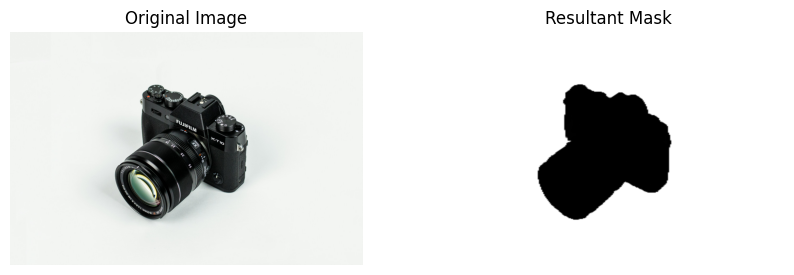

Mask image saved at: C:\Users\Aditya PC\Desktop\u2netImageOutpainting\testing_data\created_mask\test1_mask.png


In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

# Load the model architecture
model = U2Net()

# Load the saved weights
model.load_weights(r"C:\Users\Aditya PC\Desktop\u2netImageOutpainting\u2net_3.weights.h5")

# Function to preprocess image
def preprocess_image(image_path, target_size=(320, 320)):
    image = Image.open(image_path)
    original_size = image.size  # Keep track of original image size
    image = image.resize(target_size, Image.BILINEAR)
    image = np.array(image) / 255.0  # Normalize to [0, 1]
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    return image, original_size

def postprocess_mask(mask, original_size):
    mask = np.squeeze(mask)  # Remove batch dimension
    mask = (mask * 255).astype(np.uint8)  # Scale to [0, 255]
    mask = 255 - mask  # Invert the mask
    mask_image = Image.fromarray(mask).resize(original_size, Image.BILINEAR)  # Resize to match original image size
    return mask_image


# Load and preprocess the random image
image_path = r"C:\Users\Aditya PC\Desktop\u2netImageOutpainting\testing_data\images\test1.jpg"
preprocessed_image, original_size = preprocess_image(image_path)

# Run inference
predicted_mask = model.predict(preprocessed_image)

# Postprocess the mask to match the original image size
mask_image = postprocess_mask(predicted_mask[0], original_size)

# Save the mask image to a directory
save_dir = r"C:\Users\Aditya PC\Desktop\u2netImageOutpainting\testing_data\created_mask"
os.makedirs(save_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Save the mask image with the same name as the original image, but with '_mask' appended
mask_image_name = os.path.splitext(os.path.basename(image_path))[0] + '_mask.png'
mask_image.save(os.path.join(save_dir, mask_image_name))

# Display the original image and the resultant mask
original_image = Image.open(image_path)
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Original Image')
plt.imshow(original_image)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title('Resultant Mask')
plt.imshow(mask_image, cmap='gray')
plt.axis('off')

plt.show()

print(f"Mask image saved at: {os.path.join(save_dir, mask_image_name)}")


### Run Replicate to add background

Generated outpainted image URL: ['https://replicate.delivery/yhqm/VNTubF5Yq1pdCBUDcDTuieq7me7DYsrnSeawteuHufh1uKhbC/out-0.png']
Outpainted image saved at: C:\Users\Aditya PC\Desktop\u2netImageOutpainting\testing_data\output\test1_output.jpg


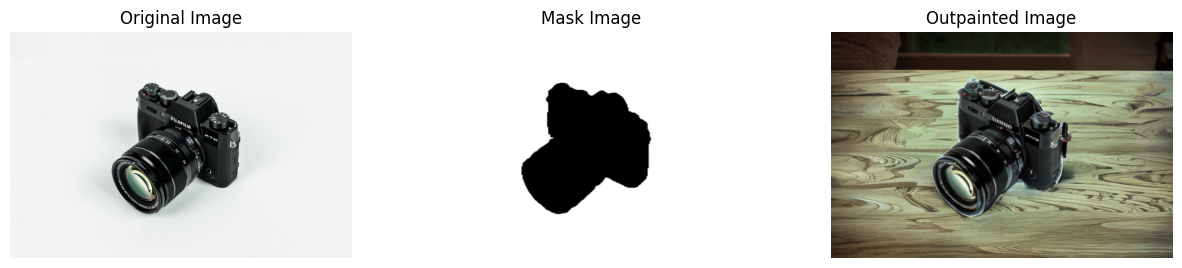

In [15]:
import os
import replicate
import requests
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Paths to your images and output directory
source_image_path = r"C:\Users\Aditya PC\Desktop\u2netImageOutpainting\testing_data\images\test1.jpg"
mask_dir = r"C:\Users\Aditya PC\Desktop\u2netImageOutpainting\testing_data\created_mask"
output_dir = r"C:\Users\Aditya PC\Desktop\u2netImageOutpainting\testing_data\output"

# Mask image path constructed from the source image name
source_image_name = os.path.basename(source_image_path)
mask_image_name = os.path.splitext(source_image_name)[0] + '_mask.png'
mask_image_path = os.path.join(mask_dir, mask_image_name)

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Set up the Replicate API client using the token stored in environment variables
api_token = os.getenv("REPLICATE_API_TOKEN")
if not api_token:
    raise EnvironmentError("Replicate API token not found. Please set the REPLICATE_API_TOKEN environment variable.")

# Function to resize the output image to the original image size
def resize_image_to_match(original_image_path, output_image):
    original_image = Image.open(original_image_path)
    original_size = original_image.size  # Get original image size
    return output_image.resize(original_size, Image.BILINEAR)  # Resize output image

# Perform image inpainting using Replicate API
try:
    # Open the images
    with open(mask_image_path, "rb") as mask_file, open(source_image_path, "rb") as image_file:
        output = replicate.run(
            "stability-ai/stable-diffusion-inpainting:95b7223104132402a9ae91cc677285bc5eb997834bd2349fa486f53910fd68b3",
            input={
                "mask": mask_file,
                "image": image_file,
                "width": 512,
                "height": 512,
                "prompt": "a wooden table",
                "scheduler": "DPMSolverMultistep",
                "num_outputs": 1,
                "guidance_scale": 7.5,
                "num_inference_steps": 25
            }
        )

    # Print the output URL
    print("Generated outpainted image URL:", output)

    # Save the output image
    output_url = output[0]  # Extract the URL from the list
    response = requests.get(output_url)

    # Check if the request was successful
    if response.status_code == 200:
        # Save the outpainted image to the output directory
        outpainted_image_name = os.path.splitext(source_image_name)[0] + '_output.jpg'
        outpainted_image_path = os.path.join(output_dir, outpainted_image_name)
        with open(outpainted_image_path, 'wb') as f:
            f.write(response.content)
        
        # Load the saved output image
        outpainted_image = Image.open(outpainted_image_path)

        # Resize the output image to match the original image size
        resized_outpainted_image = resize_image_to_match(source_image_path, outpainted_image)
        resized_outpainted_image.save(outpainted_image_path)  # Save the resized output image

        print(f"Outpainted image saved at: {outpainted_image_path}")

    else:
        print(f"Failed to download the image. Status code: {response.status_code}")

    # Display the original image, mask, and outpainted image
    original_image = Image.open(source_image_path)
    mask_image = Image.open(mask_image_path)

    # Display all three images side by side
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.title('Original Image')
    plt.imshow(original_image)
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.title('Mask Image')
    plt.imshow(mask_image, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.title('Outpainted Image')
    plt.imshow(resized_outpainted_image)
    plt.axis('off')

    plt.show()

except Exception as e:
    print(f"An error occurred: {e}")
